4.5 오토인코더

In [1]:
import tensorflow.keras
from tensorflow.keras import optimizers, losses, regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from tensorflow.keras.callbacks import TensorBoard

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.manifold import TSNE

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#%matplotlib inline
import tensorflow 
import sys

오토인코더 시각화

In [2]:
labels = ["normal", "anomaly"]
# 실제 및 예측 라벨
def draw_confusion_matrix(y, ypred):
    matrix = confusion_matrix(y, ypred)
    plt.figure(figsize=(10, 8))
    colors=[ "orange","green"]
    #sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
    sns.heatmap(matrix, xticklabels=labels, yticklabels=labels, cmap=colors, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
# reconstruction error에 따른 anomaly 
def draw_anomaly(y, error, threshold):
    groupsDF = pd.DataFrame({'error': error, 'true': y}).groupby('true')
    figure, axes = plt.subplots(figsize=(12, 8))
    for name, group in groupsDF:
        axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',\
            color='r' if name == 1 else 'g', label="anomaly" if name == 1 else "normal")
    axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
    axes.legend()
        
    plt.title("Anomalies")
    plt.ylabel("ReconstructionError")
    plt.xlabel("AMI Meter")
    plt.show()
    
# 데이터 포인트들의 reconstruction error
def draw_error(error, threshold):
    plt.plot(error, marker='o', ms=3.5, linestyle='', label='Point')
    plt.hlines(threshold, xmin=0, xmax=len(error)-1, colors="b", zorder=100, label='Threshold')
    plt.legend()
    plt.title("Reconstruction error")
    plt.ylabel("Error")
    plt.xlabel("Data")
    plt.show()

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as Fn
from pyspark.sql.functions import when, col

spark = SparkSession.builder.getOrCreate()

data = spark.read.orc("hdfs://nameserver/apps/spark/warehouse/cs_oneH_features")

In [4]:
df = data.toPandas()

In [5]:
# 241 days, meter_id, dcu_id, 24 x 241 = 5784 coluimns -> 5786 columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Columns: 5786 entries, LP_METER_ID to daily_202008022300
dtypes: float64(5784), object(2)
memory usage: 6.0+ MB


In [6]:
df.isnull().values.any()

False

In [7]:
t = df.iloc[:,2:]
t.shape

(135, 5784)

In [10]:
tt = t.values.reshape((135, 5784 // 24, 24))
tt.shape

(135, 241, 24)

In [12]:
tt[:1]

array([[[0.97900391, 0.84912109, 0.85400391, ..., 1.04589844,
         0.94287109, 0.93603516],
        [0.87695312, 0.86523438, 0.82470703, ..., 0.84570312,
         0.97900391, 0.82617188],
        [0.76318359, 0.75195312, 0.72998047, ..., 1.01513672,
         0.86914062, 0.84472656],
        ...,
        [1.16308594, 1.015625  , 0.91210938, ..., 1.12988281,
         1.04980469, 1.03125   ],
        [0.91894531, 0.90332031, 0.90527344, ..., 1.60644531,
         1.08007812, 1.04394531],
        [0.98339844, 0.96582031, 0.93359375, ..., 1.2109375 ,
         1.0625    , 1.02929688]]])

In [30]:
t = df.iloc[:, 2:]
t.head()
#te = np.array(np.split(df.iloc[:,2:], df.iloc[:,2:].shape[1]/ 24, axis=1))
#te.shape

,daily_201912060000,daily_201912060100,daily_201912060200,daily_201912060300,daily_201912060400,daily_201912060500,daily_201912060600,daily_201912060700,daily_201912060800,daily_201912060900,...,daily_202008021400,daily_202008021500,daily_202008021600,daily_202008021700,daily_202008021800,daily_202008021900,daily_202008022000,daily_202008022100,daily_202008022200,daily_202008022300
0,0.979004,0.849121,0.854004,0.803223,0.773926,0.769043,0.344727,0.423340,0.271973,0.252930,...,0.382812,0.388672,0.392578,0.470703,0.960938,1.142578,1.167969,1.210938,1.062500,1.029297
1,0.098999,0.125977,0.119995,0.140991,0.174011,0.101013,0.041992,0.031982,0.048035,0.023987,...,0.024902,0.025024,0.024048,0.025024,0.023926,0.020996,0.019043,0.022949,0.024048,0.025024
2,0.252197,0.218994,0.179932,0.156006,0.144043,0.358887,0.272949,0.127197,0.131836,0.156982,...,0.114258,0.102051,0.202637,0.181152,0.241211,0.198730,0.185059,0.256836,0.736328,0.898926
3,0.443848,0.444824,0.444336,0.452637,0.533203,0.513184,0.379883,0.337891,0.335938,0.475098,...,0.437012,0.300293,0.313965,0.359863,0.393066,0.419922,0.394043,0.443848,0.406250,0.409180
4,0.876953,0.808105,0.836914,0.839844,0.799316,0.661133,0.607910,0.601074,0.529785,0.469238,...,0.336914,0.347656,0.580078,1.141602,1.082031,1.081055,1.087891,1.052734,1.042969,1.057617


In [49]:
te = np.hsplit(t, 241)

In [51]:
te[0].shape

(135, 24)

In [18]:
# 특징 데이터셋과 범주형 컬럼 특징 처리 - 동일
from pyspark.sql import SparkSession
from pyspark.sql import functions as Fn
from pyspark.sql.functions import when, col

spark = SparkSession.builder.getOrCreate()

data = spark.read.orc("hdfs://nameserver/apps/spark/warehouse/cs_daily_features")
df = data.toPandas()

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

# 학습 입력 컬럼
input_cols = df.columns[2:].tolist()
dcu_cols = df.columns[1]

# DCU ID를 Integer 라벨로 변환
le = LabelEncoder()
le.fit(df[dcu_cols])
df["dcu_label"] = le.transform(df[dcu_cols])

# Integer 라벨을 이진 벡터로 표현
ohe = OneHotEncoder()
x = ohe.fit_transform(df.dcu_label.values.reshape(-1,1)).toarray()
dfOneHot = pd.DataFrame(x, columns = ["dcu_"+str(int(i)) for i in range(x.shape[1])]) 
df = pd.concat([df, dfOneHot], axis=1)

# 데이터 정규화
scaler = MinMaxScaler()
scaler.fit(df[input_cols])
df[input_cols]= scaler.transform(df[input_cols])

# one hot encoded columns 추가
input_cols.extend(dfOneHot.columns)

In [ ]:
"""
    2019년 12월 8일 ~ 2020년 8월 1일 일/월/화/수/목/금/토
    첫 번째 데이터셋을 20191208draw_confusion_matrix(df["anomalies"], df["label"]) ~ 20200406, 17주 (119일)
    두 번째 데이터셋을 20200405 ~ 20200801, 17주 (119일)
"""

전력 사용 이상 미터 라벨링 - Isolation Forest (Spark & Scikit-learn) & DBSCAN NTL Results

In [19]:
print(anomaly_id_list_spark_if)
print(anomaly_id_list_sklearn_if)
print(anomaly_id_list_dbscan)

['99260000364', '99260000214', '99260000390', '99260000322', '99260000446', '99260000127', '99260000268', '99260000188', '99260000106', '99260000014', '99260000478', '99260000191', '99260000361']
['99260000214', '99260000321', '99260000390', '99260000322', '99260000127', '99260000268', '99260000147', '99260000188', '99260000106', '99260000014', '99260000478', '99260000191', '99260000361']


In [21]:
anomaly_id_list_spark_if = ['99260000364', '99260000214', '99260000390', '99260000322', '99260000446', '99260000127', '99260000268', '99260000188', '99260000106', '99260000014', '99260000478', '99260000191', '99260000361']
anomaly_id_list_sklearn_if = ['99260000214', '99260000321', '99260000390', '99260000322', '99260000127', '99260000268', '99260000147', '99260000188', '99260000106', '99260000014', '99260000478', '99260000191', '99260000361']
anomaly_id_list_dbscan = ['99260000364', '99260000214', '99260000321', '99260000390', '99260000322', '99260000268', '99260000147', '99260000188', '99260000106', '99260000014', '99260000478', '99260000191', '99260000361']
anomaly_id_list = list(set(anomaly_id_list_spark_if + anomaly_id_list_sklearn_if + anomaly_id_list_dbscan))
y_anomalies = []
for id in df.LP_METER_ID.values.tolist():
    if id in anomaly_id_list:
        y_anomalies.append(1)
    else: y_anomalies.append(0)
df["anomalies"] = y_anomalies
df["LP_METER_ID"][df["anomalies"]==1]

4     99260000364
6     99260000214
22    99260000321
29    99260000390
46    99260000322
58    99260000446
61    99260000127
63    99260000268
67    99260000147
73    99260000188
77    99260000106
80    99260000014
87    99260000478
89    99260000191
90    99260000361
Name: LP_METER_ID, dtype: object

미터의 미터별 일별 사용량 + DCU ID 특징 데이터셋을 train 및 test로 분리
전력 사용 이상으로 라벨링된 df["anomalies"]를 향후 오토인코더 성능 평가에 활용

In [22]:
x_train, x_test, y_train, y_test = train_test_split(df[input_cols], df["anomalies"], test_size=0.2, random_state=42)
print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')

(108, 246) train samples
(27, 246) test samples


In [23]:
딥 오토인코더 모델
tensorboard --logdir=/home/ambari/anomaly_detection/deepautoencoder

SyntaxError: invalid syntax (<ipython-input-23-941393b089a3>, line 1)

In [26]:
logfilename = "deepautoencoder"

encoding_dim = 28
input_dim = x_train.shape[1]

inputs = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(inputs)
encoded = Dense(encoding_dim // 2, activation='relu')(encoded)
encoded = Dense(encoding_dim // 4, activation='relu')(encoded)

decoded = Dense(encoding_dim // 2, activation='relu')(encoded)
decoded = Dense(encoding_dim, activation='relu')(decoded)
decoded = Dense(input_dim, activation='softmax')(decoded)

autoencoder = Model(inputs, decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 246)]             0         
_________________________________________________________________
dense (Dense)                (None, 28)                6916      
_________________________________________________________________
dense_1 (Dense)              (None, 14)                406       
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 105       
_________________________________________________________________
dense_3 (Dense)              (None, 14)                112       
_________________________________________________________________
dense_4 (Dense)              (None, 28)                420       
_________________________________________________________________
dense_5 (Dense)              (None, 246)               7134  

In [27]:
autoencoder.compile(optimizer="rmsprop", loss="mean_squared_error", metrics=["mae", "accuracy"])
batch_size = 16
epochs = 100
history = autoencoder.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, 
                          validation_split=0.1, callbacks=[TensorBoard(log_dir='/home/ambari/anomaly_detection/{0}'.format(logfilename))])

Train on 97 samples, validate on 11 samples
Epoch 1/100
97/97 [==============================] - 2s 22ms/sample - loss: 0.1104 - mae: 0.2584 - accuracy: 0.0000e+00 - val_loss: 0.0405 - val_mae: 0.1679 - val_accuracy: 0.0000e+00
Epoch 2/100
97/97 [==============================] - 0s 5ms/sample - loss: 0.1104 - mae: 0.2584 - accuracy: 0.0000e+00 - val_loss: 0.0405 - val_mae: 0.1678 - val_accuracy: 0.0000e+00
Epoch 3/100
97/97 [==============================] - 1s 5ms/sample - loss: 0.1104 - mae: 0.2583 - accuracy: 0.0000e+00 - val_loss: 0.0404 - val_mae: 0.1678 - val_accuracy: 0.0000e+00
Epoch 4/100
97/97 [==============================] - 1s 8ms/sample - loss: 0.1103 - mae: 0.2583 - accuracy: 0.0000e+00 - val_loss: 0.0404 - val_mae: 0.1678 - val_accuracy: 0.0000e+00
Epoch 5/100
97/97 [==============================] - 0s 5ms/sample - loss: 0.1103 - mae: 0.2583 - accuracy: 0.0000e+00 - val_loss: 0.0404 - val_mae: 0.1678 - val_accuracy: 0.0000e+00
Epoch 6/100
97/97 [=====================

97/97 [==============================] - 0s 800us/sample - loss: 0.1083 - mae: 0.2584 - accuracy: 0.8144 - val_loss: 0.0380 - val_mae: 0.1680 - val_accuracy: 0.9091
Epoch 93/100
97/97 [==============================] - 0s 1ms/sample - loss: 0.1083 - mae: 0.2584 - accuracy: 0.8144 - val_loss: 0.0382 - val_mae: 0.1683 - val_accuracy: 0.9091
Epoch 94/100
97/97 [==============================] - 0s 816us/sample - loss: 0.1084 - mae: 0.2585 - accuracy: 0.8247 - val_loss: 0.0379 - val_mae: 0.1679 - val_accuracy: 0.9091
Epoch 95/100
97/97 [==============================] - 0s 1ms/sample - loss: 0.1083 - mae: 0.2584 - accuracy: 0.8351 - val_loss: 0.0379 - val_mae: 0.1679 - val_accuracy: 0.9091
Epoch 96/100
97/97 [==============================] - 0s 2ms/sample - loss: 0.1083 - mae: 0.2584 - accuracy: 0.8351 - val_loss: 0.0379 - val_mae: 0.1679 - val_accuracy: 0.9091
Epoch 97/100
97/97 [==============================] - 0s 2ms/sample - loss: 0.1083 - mae: 0.2584 - accuracy: 0.8247 - val_loss: 0

테스트 데이터셋에 대한 평가, 데이터 수 관련 이슈

In [28]:
score = autoencoder.evaluate(x_test, x_test, verbose=1)
print('Test loss:', score[0])
print('Test mae:', score[1])
print('Test accuracy:', score[2])

27/27 [==============================] - 0s 661us/sample - loss: 0.0904 - mae: 0.2466 - accuracy: 0.8889
Test loss: 0.090375155210495
Test mae: 0.24662791
Test accuracy: 0.8888889


특징 데이터셋을 예측하고 실제 값과 예측 값 간 reconstruction error 계산

In [29]:
y_pred = autoencoder.predict(df[input_cols])
y_dist = np.linalg.norm(df[input_cols] - y_pred, axis=-1)
y_dist.sort()
cut_point = int(0.89*len(y_dist))
threshold = y_dist[cut_point]
dist = np.linalg.norm(df[input_cols] - y_pred, axis=-1)

z = zip(dist >= threshold, dist)
y_label=[]
error = []
for idx, (is_anomaly, dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(dist)
df['label'] = y_label
df[["LP_METER_ID", "LP_DCU_ID"]][df['label']==1]

,LP_METER_ID,LP_DCU_ID
2,99260000273,DCU__TG70C
4,99260000364,DCU_0DK242
6,99260000214,DCU_0TG312
11,99260000430,DCU_0DK242
29,99260000390,DCU_0DK242
46,99260000322,DCU_0TG312
63,99260000268,DCU__TG70C
67,99260000147,DCU_00DK94
73,99260000188,DCU_00DK94
77,99260000106,DCU_0TG312


재구성 에러 시각화

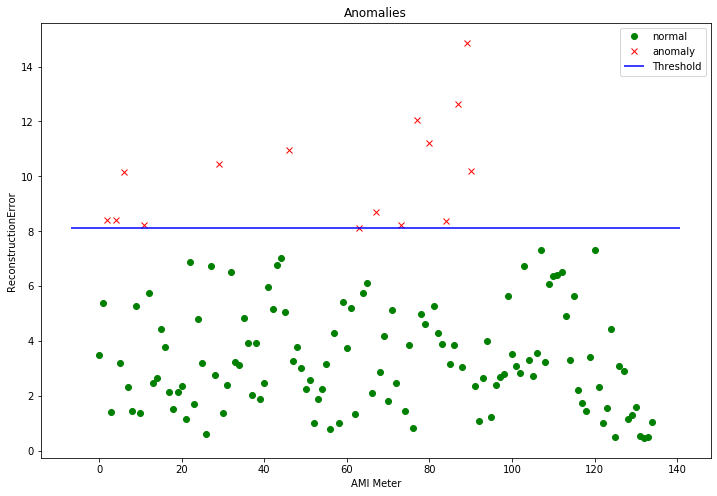

In [30]:
draw_anomaly(y_label, error, threshold)

오토인코더 기반 전력 사용 이상 미터 목록

In [31]:
anomaly = df.loc[df['label']==1]
anomaly_index_autoencoder = list(anomaly.index)
anomaly_id_list_autoencoder = df["LP_METER_ID"].iloc[anomaly_index_autoencoder].tolist()
print("전력 사용이 의심되는 미터 목록")
print(anomaly_id_list_autoencoder)

전력 사용이 의심되는 미터 목록
['99260000273', '99260000364', '99260000214', '99260000430', '99260000390', '99260000322', '99260000268', '99260000147', '99260000188', '99260000106', '99260000014', '99260000438', '99260000478', '99260000191', '99260000361']


DCU 별 전력 사용 이상 미터 목록

In [32]:
meter_id_per_dcu = df[["LP_DCU_ID", "LP_METER_ID"]].iloc[anomaly_index_autoencoder].groupby("LP_DCU_ID")
print(meter_id_per_dcu["LP_METER_ID"].apply(list).index)
meter_id_per_dcu["LP_METER_ID"].apply(list).values

Index(['DCU_00DK94', 'DCU_0DK242', 'DCU_0TG312', 'DCU__TG70C'], dtype='object', name='LP_DCU_ID')


array([list(['99260000147', '99260000188', '99260000014', '99260000191']),
       list(['99260000364', '99260000430', '99260000390', '99260000478']),
       list(['99260000214', '99260000322', '99260000106']),
       list(['99260000273', '99260000268', '99260000438', '99260000361'])],
      dtype=object)

딥 오토인코더 데이터 시각화

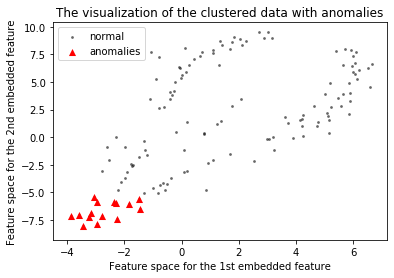

In [33]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D


tsne = TSNE(n_components=2, init="pca", random_state=0)
df_reduce = tsne.fit_transform(df[input_cols])

# 정상 데이터 포인트 플롯 
plt.scatter(df_reduce[:, 0], df_reduce[:, 1], marker='.', s=30, lw=0, alpha=0.6, c="black", edgecolor='k', label="normal")

# 이상 데이터 포인트 플롯
plt.scatter(df_reduce[anomaly_index_autoencoder, 0], df_reduce[anomaly_index_autoencoder, 1], marker='^', s=50, lw=0, alpha=1, c="red", edgecolor='k', label="anomalies")

plt.title("The visualization of the clustered data with anomalies")
plt.xlabel("Feature space for the 1st embedded feature")
plt.ylabel("Feature space for the 2nd embedded feature")
plt.legend()
plt.show()

딥 오토인코더 분류 결과표

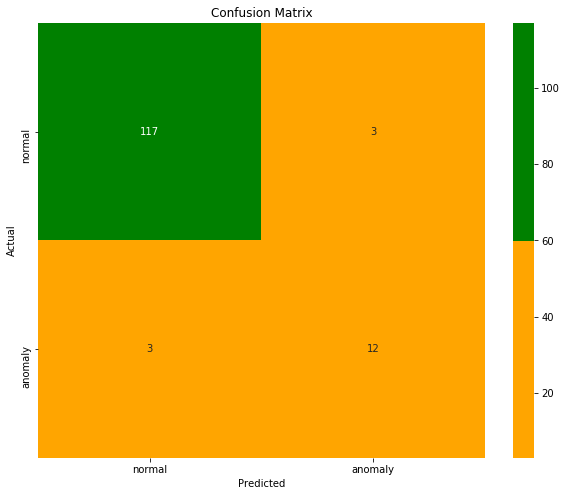

In [34]:
draw_confusion_matrix(df["anomalies"], df["label"])

딥 오토인코더 신경망의 평가 점수 - 탐지율 80%

In [35]:
print(classification_report(df["anomalies"], df["label"]))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       120
           1       0.80      0.80      0.80        15

    accuracy                           0.96       135
   macro avg       0.89      0.89      0.89       135
weighted avg       0.96      0.96      0.96       135



ROC_AUC 스코어

In [36]:
print(roc_auc_score(df["anomalies"], df["label"]))

0.8875


In [ ]:
LSTMAutoEncoder, CnnLSTMAutoEncoder
LstmAutoEncoder 적용을 위해 특징 데이터셋에서 DCU ID 라벨 제외
STM 적용을 위한 (N_samples, time_steps, n_features)로 reshape. 여기서 n_features=1

In [37]:
# 특징 데이터셋과 범주형 컬럼 특징 처리 - 동일
from pyspark.sql import SparkSession
from pyspark.sql import functions as Fn
from pyspark.sql.functions import when, col

spark = SparkSession.builder.getOrCreate()

data = spark.read.orc("hdfs://nameserver/apps/spark/warehouse/cs_daily_features")
df = data.toPandas()

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

# 학습 입력 컬럼
input_cols = df.columns[2:].tolist()
dcu_cols = df.columns[1]

# 데이터 정규화
scaler = MinMaxScaler()
scaler.fit(df[input_cols])
df[input_cols]= scaler.transform(df[input_cols])

In [38]:
print(df.shape[0])
print(df.shape)
print(df[input_cols].shape[0])
print(df[input_cols].shape)
df[input_cols].head()

135
(135, 243)
135
(135, 241)


,daily_20191206,daily_20191207,daily_20191208,daily_20191209,daily_20191210,daily_20191211,daily_20191212,daily_20191213,daily_20191214,daily_20191215,...,daily_20200724,daily_20200725,daily_20200726,daily_20200727,daily_20200728,daily_20200729,daily_20200730,daily_20200731,daily_20200801,daily_20200802
0,0.173581,0.180371,0.229221,0.146944,0.223702,0.137285,0.090034,0.111764,0.212828,0.153309,...,0.256542,0.213749,0.276368,0.173305,0.233952,0.218244,0.246787,0.237103,0.231824,0.233857
1,0.320483,0.335652,0.331445,0.287414,0.345113,0.319003,0.350987,0.287922,0.328212,0.262786,...,0.292801,0.240570,0.305093,0.234544,0.262072,0.304490,0.329963,0.300830,0.308897,0.287858
2,0.479176,0.414791,0.389342,0.429026,0.464931,0.422391,0.397020,0.390728,0.413903,0.375034,...,0.593283,0.606125,0.628525,0.540157,0.638810,0.658548,0.687276,0.616764,0.600411,0.602426
3,0.089880,0.096254,0.111748,0.079158,0.091936,0.082466,0.083314,0.067893,0.101022,0.064544,...,0.006450,0.008589,0.013033,0.010010,0.011336,0.012359,0.013285,0.012307,0.012674,0.012318
4,0.453261,0.456337,0.449955,0.420141,0.379675,0.345034,0.447955,0.360674,0.468259,0.376395,...,0.636525,0.518455,0.567405,0.429091,0.520532,0.560587,0.609268,0.593026,0.641269,0.576248


In [39]:
df_numeric = df[input_cols]
df_numeric.head()
ts_df = np.expand_dims(df_numeric, axis=2)
ts_df.shape

(135, 241, 1)

In [40]:
# LSTM을 적용하기에는 데이터 수가 부족 (num_rows), 실제 적용하지는 않음
x_train, x_test = train_test_split(ts_df, test_size=0.2, random_state=42)
print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')

(108, 241, 1) train samples
(27, 241, 1) test samples


In [43]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPool1D, Dense, Flatten, MaxPooling1D

time_steps = df_numeric.shape[1]

# LstmAutoEncoder
# 241 features를 128, 64 및 32 units의 lstm 적용 후 241 /2, 241 dim으로 역순으로 복원
#model = Sequential()
#model.add(LSTM(units=128, input_shape=(time_steps,1), return_sequences=True))
#model.add(LSTM(units=64,return_sequences=True ))
#model.add(LSTM(units=32, return_sequences=False))
#model.add(Dense(units=time_steps // 2, activation='relu'))
#model.add(Dense(units=time_steps, activation='softmax'))

# CnnLSTMAutoEncoder, 병렬 연산 측면에서 Lstm AutoEncoder 대안
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=5, padding='same', activation='relu',input_shape=(time_steps, 1)))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(64))
model.add(Dense(units=time_steps, activation='softmax')) 

model.compile(optimizer='rmsprop', loss='mean_absolute_error', metrics=["mae", "accuracy"])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 241, 256)          1536      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 60, 256)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                82176     
_________________________________________________________________
dense_8 (Dense)              (None, 241)               15665     
Total params: 99,377
Trainable params: 99,377
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
logfilename = "lstmautoencoder"
batch_size = 8
epochs = 20 #

history = model.fit(ts_df, df_numeric, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=False, validation_split=0.2,\
                callbacks=[TensorBoard(log_dir='/home/ambari/anomaly_detection/{0}'.format(logfilename))])